<a href="https://colab.research.google.com/github/ggoggori/Dacon/blob/main/%EC%A0%9C1%ED%9A%8C%EC%BB%B4%ED%93%A8%ED%84%B0%EB%B9%84%EC%A0%84%EA%B2%BD%EC%A7%84%EB%8C%80%ED%9A%8C.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Python import

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
from torchvision import datasets, models, transforms, utils 
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
%pylab inline
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import KFold, train_test_split, StratifiedShuffleSplit
from PIL import Image
import copy

Populating the interactive namespace from numpy and matplotlib


In [3]:
seed = 4

torch.manual_seed(seed)

In [4]:
data_root = '/content/drive/MyDrive/Colab Notebooks/데이콘 1회 컴퓨터 비전/data'

### Load Data

In [5]:
train = pd.read_csv(os.path.join(data_root,'train.csv'))
test = pd.read_csv(os.path.join(data_root,'test.csv'))

In [6]:
test

,id,letter,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,...,744,745,746,747,748,749,750,751,752,753,754,755,756,757,758,759,760,761,762,763,764,765,766,767,768,769,770,771,772,773,774,775,776,777,778,779,780,781,782,783
0,2049,L,0,4,0,2,4,2,3,1,0,0,1,0,1,3,4,4,0,0,2,4,4,1,3,3,2,2,4,1,0,1,2,2,1,2,2,1,4,0,...,1,3,1,1,3,3,4,1,3,1,2,4,1,2,0,3,1,2,4,0,2,1,2,4,1,1,3,2,1,0,2,0,4,2,2,4,3,4,1,4
1,2050,C,4,1,4,0,1,1,0,2,2,1,0,3,0,1,1,4,1,2,0,2,2,0,4,3,4,0,2,4,4,2,1,2,4,0,4,2,0,2,...,3,4,2,6,2,2,0,1,2,4,1,1,3,3,2,3,4,2,2,4,3,1,3,3,3,1,3,4,4,2,0,3,2,4,2,4,2,2,1,2
2,2051,S,0,4,0,1,3,2,3,0,2,1,2,0,1,0,3,0,1,4,3,0,0,3,0,4,1,0,3,2,0,4,1,2,0,0,1,3,0,2,...,0,4,4,3,4,1,4,2,3,4,1,2,0,2,2,3,3,1,1,4,1,2,4,0,0,0,0,2,3,2,1,3,2,0,3,2,3,0,1,4
3,2052,K,2,1,3,3,3,4,3,0,0,2,3,2,3,4,4,4,0,1,4,2,2,0,1,4,3,1,3,0,2,3,2,4,3,1,1,4,0,0,...,0,4,1,1,2,3,2,3,3,0,0,1,3,3,0,2,0,0,2,3,2,2,3,1,1,2,4,0,1,2,3,0,3,2,4,1,0,4,4,4
4,2053,W,1,0,1,1,2,2,1,4,1,1,4,3,4,1,2,1,4,3,3,4,0,4,4,2,0,0,0,0,3,4,0,1,4,2,2,2,1,4,...,4,1,3,2,1,2,1,4,4,1,2,3,2,4,2,1,4,3,4,3,0,1,0,1,1,2,1,1,0,2,4,3,1,4,0,2,1,2,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20475,22524,P,1,2,1,1,0,0,0,2,1,0,0,2,4,3,2,0,1,3,1,1,0,2,0,4,4,2,3,0,2,2,2,2,1,3,2,2,4,1,...,1,4,4,2,1,3,4,2,3,2,4,2,3,1,1,3,2,4,3,1,2,1,3,0,4,2,2,1,1,4,0,1,3,0,3,0,4,3,1,4
20476,22525,S,4,1,1,4,0,0,1,1,4,3,2,3,3,2,2,0,0,0,2,4,3,0,2,0,2,4,2,3,3,1,4,2,2,3,2,2,2,0,...,1,1,0,2,1,4,4,4,0,1,2,4,4,4,1,2,4,2,1,4,1,0,1,0,4,2,0,0,3,4,1,3,1,0,0,1,3,1,2,0
20477,22526,B,4,2,1,3,2,1,3,0,4,4,1,0,0,1,2,1,2,2,0,3,0,4,0,2,3,3,4,1,2,0,1,2,4,3,1,3,3,1,...,1,3,3,2,1,3,0,3,2,3,2,4,2,0,4,2,2,2,1,1,0,3,0,2,1,4,3,2,3,4,3,2,3,4,1,0,3,3,1,1
20478,22527,K,1,1,2,3,4,0,4,3,1,2,2,3,1,2,3,4,1,3,1,0,3,3,1,2,4,3,4,1,0,0,1,1,0,4,1,3,2,2,...,0,4,0,2,4,2,1,3,2,0,1,3,0,4,1,4,2,3,3,2,2,1,4,2,0,3,0,3,2,4,2,0,0,4,3,3,3,4,4,2


### EDA

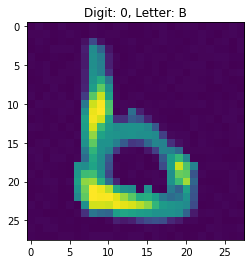

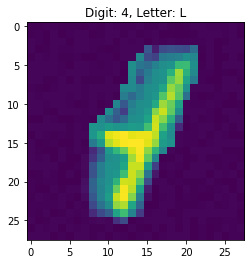

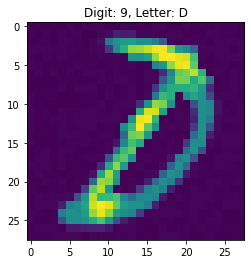

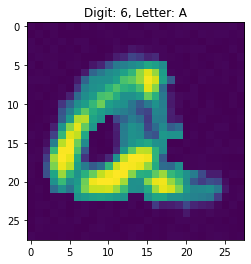

In [7]:
for idx in range(1,5):
    img = train.loc[idx, '0':].values.reshape(28, 28).astype(int)
    digit = train.loc[idx, 'digit']
    letter = train.loc[idx, 'letter']

    plt.title('Digit: %s, Letter: %s'%(digit, letter))
    plt.imshow(img)
    plt.show()

## 명암조절

In [8]:
for i, row in enumerate(img):
    for j, _ in enumerate(row):
        if img[i,j] < 150:
            img[i,j] = 0

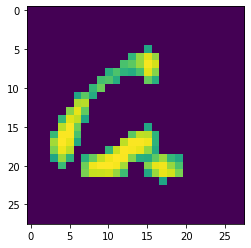

In [9]:
plt.imshow(img)

# data augmentation

In [10]:
transforms_train = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x:x.repeat(3,1,1)),
        transforms.RandomPerspective(),
        #transforms.RandomAffine(degrees=0, translate=(0.1,0.1)),
        transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

transforms_val = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x:x.repeat(3,1,1)),
        transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


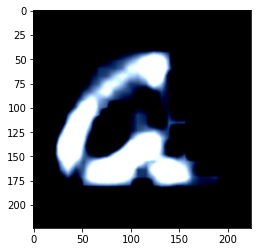

In [11]:
img = train.loc[idx, '0':].values.reshape(28, 28).astype(np.uint8)
img = transforms_train(img)
img = img.permute(1,2,0)
plt.imshow(img)

# custom dataset

In [12]:
class dataset(Dataset):
    def __init__(self, csv, dataType='train', transform=None):
        self.df = csv
        self.transform = transform
        self.dataType = dataType
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        img = self.df.loc[idx,'0':].values.reshape(28,28).astype(np.uint8)
        if self.dataType=='train':
            label = self.df.loc[idx,'digit']
        else:
            pass

        if self.transform:
            img = self.transform(img)
            
        if self.dataType=='train':
            sample = {'image':img, 'label':label}
        else:
            sample = {'image':img}
        
        return sample 

In [13]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=.2, random_state=4)

indices = list(range(len(train)))
y = train['digit'].to_list()

for train_idx, valid_idx in sss.split(indices, y):
    print(len(train_idx), len(valid_idx))

1638 410


In [14]:
train_df = train.loc[train_idx].reset_index(drop=True)
valid_df = train.loc[valid_idx].reset_index(drop=True)

In [15]:
train_dataset = dataset(train_df, transform=transforms_train)
valid_dataset = dataset(valid_df, transform=transforms_val)
test_dataset = dataset(test, dataType='test', transform=transforms_val)

# data_loader

In [16]:
train_loader = DataLoader(train_dataset,  batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [17]:
samples = next(iter(train_loader))
print(samples['image'][0],'\n', samples['image'].shape)
print(samples['label'][0],'\n', samples['label'].shape)
# samples = next(iter(valid_loader))
# print(samples['image'][0],'\n', samples['image'].shape)
# print(samples['label'][0],'\n', samples['label'].shape)

tensor([[[-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         ...,
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
         [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],

        [[-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         ...,
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
         [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],

        [[-1.8044, -1.8044, -1.8044,  ..., -1.8044, -1.8044, -1.8044],
         [-1.8044, -1.8044, -1.8044,  ..., -1

# build model

In [18]:
!pip install efficientnet_pytorch

  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-cp37-none-any.whl size=16443 sha256=bda83248288e07130931889a123d6032c53dc9263304c3fedc64917e6738fdfd
  Stored in directory: /root/.cache/pip/wheels/84/27/aa/c46d23c4e8cc72d41283862b1437e0b3ad318417e8ed7d5921
Successfully built efficientnet-pytorch


In [19]:
from efficientnet_pytorch import EfficientNet
model = EfficientNet.from_name('efficientnet-b3', num_classes=10)

In [20]:
output = model(samples['image'])

In [21]:
USE_CUDA = torch.cuda.is_available()
print(USE_CUDA)

device = torch.device('cuda:0' if USE_CUDA else 'cpu')
print('학습 공간:',device)

model = model.to(device)

True
학습 공간: cuda:0


# train

In [22]:
criterion = nn.CrossEntropyLoss()
num_epochs = 500
best_val_acc, patience = 0, 0
results = {'train_loss':[], 'train_acc':[], 'valid_loss':[], 'valid_acc':[]}
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',verbose=True)

modelPath = '/content/drive/MyDrive/Colab Notebooks/데이콘 1회 컴퓨터 비전/model#(aug비교)'
os.makedirs(modelPath, exist_ok=True)

In [ ]:
for epoch in range(0, num_epochs):

    model.train()
    current_loss, correct ,total = 0,0,0
    print(f'Starting epoch [{epoch+1}/{num_epochs}]')
    
    for i, data in enumerate(train_loader):

        inputs, targets = data['image'].to(device), data['label'].to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        
        current_loss += loss.item()
        
        total += targets.size(0)
        _, pred = torch.max(output, 1)
        correct += (pred==targets).sum()
        
    train_acc = correct.cpu().numpy()/total
    print('[train] ACC:{} / loss:{}'.format(round(train_acc,5),current_loss)) 
    results['train_loss'].append(current_loss)
    results['train_acc'].append(train_acc)

    model.eval()
    current_loss, correct ,total = 0,0,0
    
    with torch.no_grad():
        for i, data in enumerate(valid_loader):
            inputs, targets = data['image'].to(device), data['label'].to(device)
            output = model(inputs)
            loss = criterion(output, targets)
            current_loss += loss
            _, predicted = torch.max(output, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum()
        valid_acc = correct.cpu().numpy()/total
        print('[valid] ACC:{} / loss:{}'.format(round(valid_acc,5),current_loss))
        
        results['valid_loss'].append(current_loss)
        results['valid_acc'].append(valid_acc)

    scheduler.step(current_loss)

    if valid_acc > best_val_acc:
        best_val_acc = valid_acc
        patience = 0
        torch.save(model.state_dict(),os.path.join(modelPath,'model_perspective'+'weight.pt'))
        print(f'model saved at {epoch} epoch')

    else:
        patience += 1
        print("Counter {} of 30".format(patience))

        if patience >= 30:
            print("Early stopping with best_acc: ", best_val_acc, "and val_acc for this epoch: ", valid_acc, "...")
            break
    print('-------------------------------')    


        

Starting epoch [1/500]
[train] ACC:0.11111 / loss:128.79493618011475
[valid] ACC:0.1 / loss:29.951478958129883
model saved at 0 epoch
-------------------------------
Starting epoch [2/500]
[train] ACC:0.20452 / loss:114.76413857936859
[valid] ACC:0.10244 / loss:30.0427188873291
model saved at 1 epoch
-------------------------------
Starting epoch [3/500]
[train] ACC:0.33639 / loss:97.31078898906708
[valid] ACC:0.10976 / loss:29.976825714111328
model saved at 2 epoch
-------------------------------
Starting epoch [4/500]
[train] ACC:0.47802 / loss:79.59800279140472
[valid] ACC:0.11463 / loss:30.138032913208008
model saved at 3 epoch
-------------------------------
Starting epoch [5/500]
[train] ACC:0.558 / loss:69.2411796450615
[valid] ACC:0.09756 / loss:37.462867736816406
Counter 1 of 30
-------------------------------
Starting epoch [6/500]
[train] ACC:0.60073 / loss:61.48096936941147
[valid] ACC:0.0878 / loss:35.091861724853516
Counter 2 of 30
-------------------------------
Starting

# visualiazation

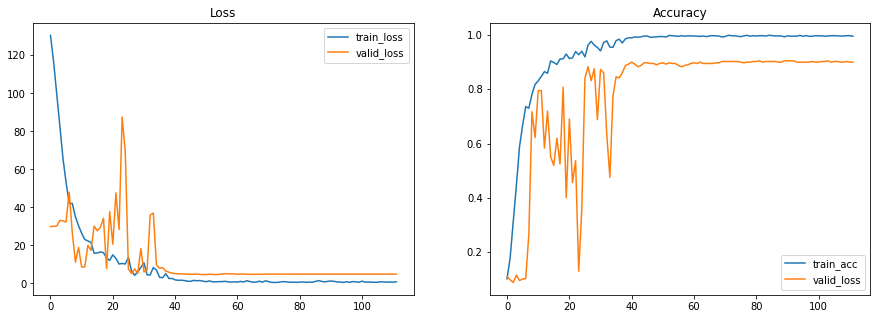

In [27]:
fig, axes = plt.subplots(1,2 ,figsize=(15,5))

axes[0].plot(results['train_loss'], label='train_loss')
axes[0].plot(results['valid_loss'],label='valid_loss')
axes[0].set_title('Loss')
axes[0].legend()

axes[1].plot(results['train_acc'], label='train_acc')
axes[1].plot(results['valid_acc'], label='valid_loss')
axes[1].set_title('Accuracy')
axes[1].legend()
plt.show()

# finetuning with valid set

In [ ]:
num_epochs = 10

for epoch in range(0, num_epochs):

    model.train()
    current_loss, correct ,total = 0,0,0
    print(f'Starting epoch [{epoch+1}/{num_epochs}]')
    
    for i, data in enumerate(valid_loader):

        inputs, targets = data['image'].to(device), data['label'].to(device)
        optimizer.zero_grad()
        output = model(inputs)
        loss = criterion(output, targets)
        loss.backward()
        optimizer.step()
        
        current_loss += loss.item()
        
        total += targets.size(0)
        _, pred = torch.max(output, 1)
        correct += (pred==targets).sum()
        
    train_acc = correct.cpu().numpy()/total
    print('[valid finetuning] ACC:{} / loss:{}'.format(round(train_acc,5),current_loss)) 
    
torch.save(model.state_dict(),os.path.join(modelPath,'[valid_finetuned]model_'+'weight.pt'))

Starting epoch [1/10]
[valid finetuning] ACC:0.87561 / loss:5.0227727591991425
Starting epoch [2/10]
[valid finetuning] ACC:0.88293 / loss:4.9864615350961685
Starting epoch [3/10]
[valid finetuning] ACC:0.86585 / loss:5.331867665052414
Starting epoch [4/10]
[valid finetuning] ACC:0.8561 / loss:6.116969555616379
Starting epoch [5/10]
[valid finetuning] ACC:0.87317 / loss:5.026117518544197
Starting epoch [6/10]
[valid finetuning] ACC:0.85366 / loss:5.503688372671604
Starting epoch [7/10]
[valid finetuning] ACC:0.87073 / loss:5.814787782728672
Starting epoch [8/10]
[valid finetuning] ACC:0.88049 / loss:5.40111617743969
Starting epoch [9/10]
[valid finetuning] ACC:0.88293 / loss:5.3604386895895
Starting epoch [10/10]
[valid finetuning] ACC:0.86585 / loss:5.203398168087006


# TTA

In [ ]:
modelPath = '/content/drive/MyDrive/Colab Notebooks/데이콘 1회 컴퓨터 비전/model#2'
model = EfficientNet.from_name('efficientnet-b3', num_classes=10)
model.load_state_dict(torch.load(os.path.join(modelPath,'model_'+'weight.pt')))
model = model.to(device)

In [ ]:
transforms_train = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x:x.repeat(3,1,1)),
        transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
])

In [ ]:
tt = transforms.RandomPerspective(p=0.5, distortion_scale=0.5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


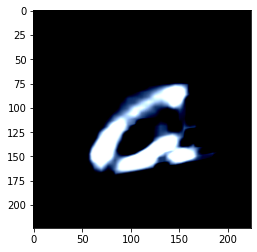

In [ ]:
img = train.loc[idx, '0':].values.reshape(28, 28).astype(np.uint8)
img = transforms_train(img)
img = tt(img)
img = img.permute(1,2,0)
plt.imshow(img)

# Inference

In [28]:
submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/데이콘 1회 컴퓨터 비전/data/submission.csv')

In [29]:
labels = []
for i, data in enumerate(test_loader):
    with torch.no_grad():
        model.eval()
        images = data['image'].to(device)
        output = model(images)
        _, pred = torch.max(output, 1)
        labels.extend(pred.cpu().detach().numpy())

In [30]:
submission['digit'] = labels

In [31]:
submission.to_csv('submission.csv',index=False)

In [32]:
from google.colab import files
files.download('submission.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
folds = 5
kfold = KFold(n_splits=folds, shuffle=True)
criterion = nn.CrossEntropyLoss()
num_epochs = 50
results = {}

for fold, (train_idx, test_idx) in enumerate(kfold.split(train_dataset)):
    
    print('fold: {} fold'.format(fold))
    print('------------------------------------')
    
    train_subsampler = SubsetRandomSampler(train_idx)
    test_subsampler = SubsetRandomSampler(test_idx)
    
    train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_subsampler, drop_last=True)
    test_loader = DataLoader(train_dataset, batch_size=32, sampler=test_subsampler, drop_last=True)
    
    model = efnet('efficientnet-b0', 10).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    
    for epoch in range(0, num_epochs):
        
        current_loss = 0.0
        print(f'Starting epoch {epoch+1}')
        
        model.train()
        
        for i, data in enumerate(train_loader):

            inputs, targets = data['image'].to(device), data['label'].to(device)
            optimizer.zero_grad()
            output = model(inputs.float())
            loss = criterion(output, targets)
            loss.backward()
            optimizer.step()
            
            current_loss += loss.item()
            
            if i % 500 == 499:
                print('Loss after mini-batch {}: {}'.format(i+1, current_loss/500))
                current_loss = 0.0
        
        save_path = f'./model-fold-{fold}.pth'
        torch.save(model.state_dict(), save_path)
        
        model.eval()
        correct ,total = 0,0
        
        with torch.no_grad():
            for i, data in enumerate(test_loader):
                inputs, targets = data['image'].to(device), data['label'].to(device)
                output = model(inputs.float())
                _, predicted = torch.max(output, 1)
                total += targets.size(0)
                correct += (predicted == targets).sum()

            print(correct, total)    
            print('Accuracy for fold {}: {}'.format(fold,correct / total))
            print('------------------------------------------')
            results[fold] =  correct / total
    
    print('K-fold cross validation result: {}'.format(folds))
    sum_ = 0.0

    for key, value in results.items():
        print(f'[Fold {key}] {value}')
        sum_ += value
    print(f'Average acc:{sum_/len(results.items())}%')